In [1]:
import pymysql
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from time import gmtime, strftime
import sys
import requests
import sqlalchemy
#import mysql
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import datetime

In [2]:
traffic = pd.read_excel('C:/Users/shree/3D Objects/Actual Data/Traffic count Hourly (Aug - Oct).xlsx')
traffic.shape,traffic.device_id.nunique(),traffic.date_time.min(),traffic.date_time.max()

In [3]:
traffic.head()

,client_id,area_id,device_id,date_time,date,period_type,period,traffic_count,created_date
0,17,26,PeopleCount35,2019-08-01 00:00:00,2019-08-01,half-hourly,0,0,2019-11-01 10:59:06
1,17,26,PeopleCount35,2019-08-01 00:30:00,2019-08-01,half-hourly,1,1,2019-11-01 10:59:06
2,17,26,PeopleCount35,2019-08-01 01:00:00,2019-08-01,half-hourly,2,0,2019-11-01 10:59:06
3,17,26,PeopleCount35,2019-08-01 01:30:00,2019-08-01,half-hourly,3,0,2019-11-01 10:59:06
4,17,26,PeopleCount35,2019-08-01 02:00:00,2019-08-01,half-hourly,4,0,2019-11-01 10:59:06


In [4]:
traffic_4 = traffic[(traffic.area_id == 26.0)] # 19 20 23 25 26 27 28 29

In [241]:
traffic_4.date_time.max(),traffic_4.date_time.min()

('2019-10-31 23:30:00', '2019-08-01 00:00:00')

In [242]:
grpd = pd.DataFrame(traffic_4.groupby(['date_time'])['traffic_count'].sum())
grpd.reset_index(inplace=True)

data_prp = grpd[['date_time','traffic_count']]
data_prp.columns=['ds','y']
df_train = data_prp[(data_prp['ds'] >= '2019-08-01 00:00:00') & (data_prp['ds'] <= '2019-10-24 23:30:00')]
df_test = data_prp[(data_prp.ds >= '2019-10-25 00:00:00') & (data_prp['ds'] <= '2019-10-31 23:30:00')]
 
df_train.shape,df_test.shape

((4080, 2), (336, 2))

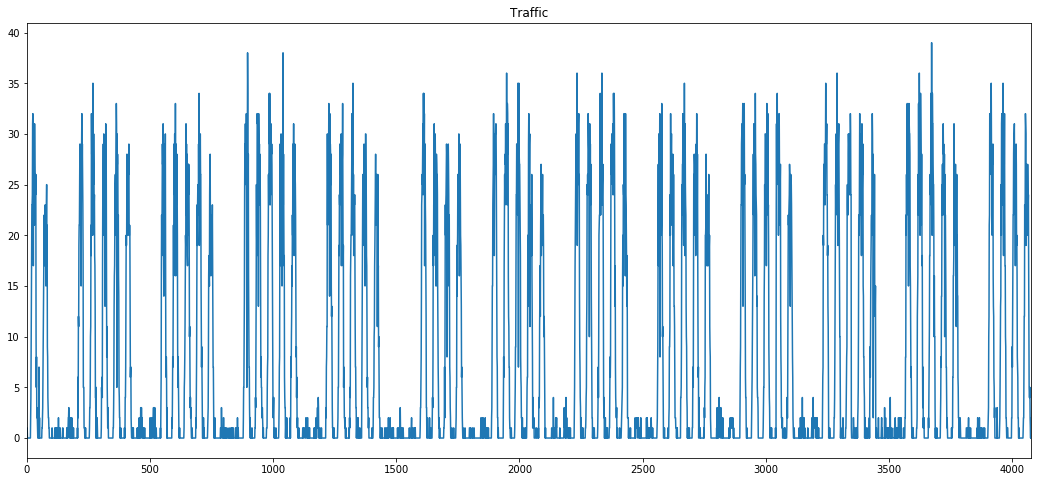

In [243]:
import matplotlib.pyplot as plt
df_train['y'].plot(figsize=(18,8))
plt.title("Traffic")
plt.show()

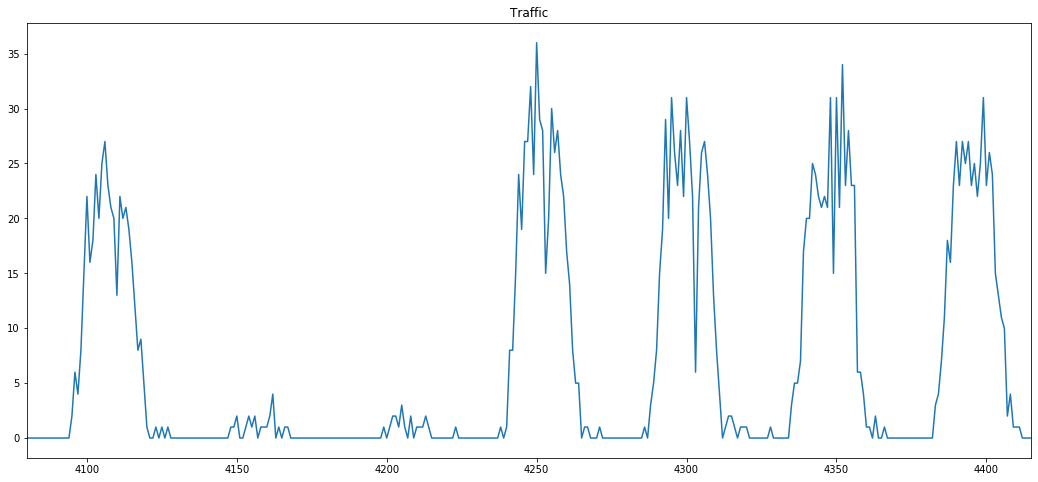

In [244]:
import matplotlib.pyplot as plt
df_test['y'].plot(figsize=(18,8))
plt.title("Traffic")
plt.show()

In [262]:
def week_ends(ds):
    date = pd.to_datetime(ds)
    if date.weekday() > 4 :
        return 1
    else:
        return 0
    
def office_hours(ds):
    date = pd.to_datetime(ds)
    if date.hour > 7 and date.hour < 21 :
        return 1
    else:
        return 0
    
def mon_fri(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 0 or date.weekday() == 4 :
        return 1
    else:
        return 0

In [246]:
df_train['week_ends'] = df_train['ds'].apply(week_ends)
df_train['office_hours'] = df_train['ds'].apply(office_hours)

df_train['mon_fri'] = df_train['ds'].apply(mon_fri)

C:\Users\shree\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\shree\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [247]:
m = Prophet(growth='linear',seasonality_mode='multiplicative',changepoint_prior_scale=48,seasonality_prior_scale=5,daily_seasonality=False,weekly_seasonality=False).add_seasonality(name='hourly',period=24,fourier_order=24).add_seasonality(name='daily',period=1,fourier_order=24).add_seasonality(name='weekly',period=7,fourier_order=48)
m.add_regressor('week_ends')
m.add_regressor('office_hours')
m.fit(df_train)
future = m.make_future_dataframe(periods=4880,freq='30min')
future['week_ends'] = future['ds'].apply(week_ends)
future['office_hours'] = future['ds'].apply(office_hours)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [248]:
future

,ds,week_ends,office_hours
0,2019-08-01 00:00:00,0,0
1,2019-08-01 00:30:00,0,0
2,2019-08-01 01:00:00,0,0
3,2019-08-01 01:30:00,0,0
4,2019-08-01 02:00:00,0,0
...,...,...,...
8955,2020-02-03 13:30:00,0,1
8956,2020-02-03 14:00:00,0,1
8957,2020-02-03 14:30:00,0,1
8958,2020-02-03 15:00:00,0,1


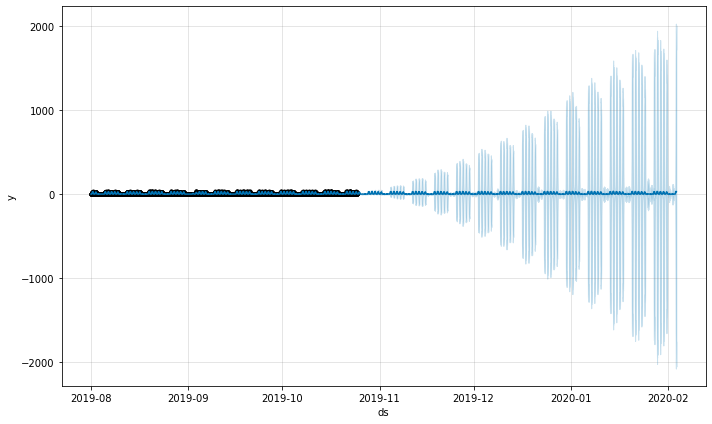

In [249]:
fcst = m.predict(future)
fig = m.plot(fcst)

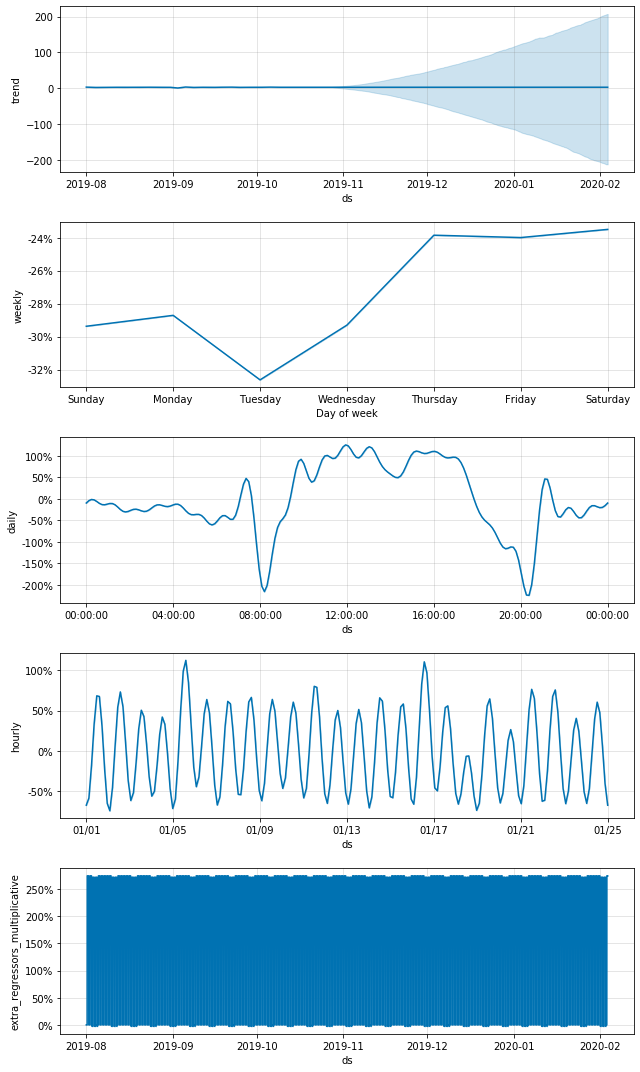

In [250]:
fig = m.plot_components(fcst)

In [251]:
pred=fcst[(fcst.ds>='2020-01-27 00:00:00') & (fcst.ds <= '2020-02-02 23:30:00')][['ds','yhat']]
act_ = pd.read_csv('Traffic - Actual - People count batch.csv')

In [252]:
act_= act_[['date_time','traffic_count']]
act_ = act_.rename(columns={'date_time':'ds'})
act_.ds = pd.to_datetime(act_.ds)

fin = pd.merge(act_,pred,on=['ds'],how='inner')
fin['yhat'] = np.where(fin.yhat < 0, 0, fin.yhat)

In [253]:
act_.head()

,ds,traffic_count
0,2020-01-27 00:00:00,0
1,2020-01-27 00:30:00,0
2,2020-01-27 01:00:00,0
3,2020-01-27 01:30:00,0
4,2020-01-27 02:00:00,0


In [254]:
metric_df = pred.set_index('ds')[['yhat']].join(act_.set_index('ds').traffic_count).reset_index()
metric_df.dropna(inplace=True)
metric_df['yhat'] = np.where(metric_df.yhat < 0 , 0 , metric_df.yhat)
metric_df['yhat'] = np.ceil(metric_df.yhat)


In [255]:
metric_df.tail()

,ds,yhat,traffic_count
331,2020-02-02 21:30:00,0.0,1
332,2020-02-02 22:00:00,1.0,0
333,2020-02-02 22:30:00,1.0,1
334,2020-02-02 23:00:00,1.0,0
335,2020-02-02 23:30:00,0.0,0


In [256]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import ml_metrics as metrics

print('r squared : ' , (r2_score(metric_df.traffic_count, metric_df.yhat)* 100))

print('mean squared error : ' , mean_squared_error(metric_df.traffic_count, metric_df.yhat))

print('mean absolute error : ' , mean_absolute_error(metric_df.traffic_count, metric_df.yhat))

print('mean absolute error : ' , metrics.mae(metric_df.traffic_count, metric_df.yhat))

print('mean absolute error : ' , metrics.rmse(metric_df.traffic_count, metric_df.yhat))

r squared :  94.22646209356344
mean squared error :  6.845238095238095
mean absolute error :  1.619047619047619
mean absolute error :  1.619047619047619
mean absolute error :  2.616340592361418


In [257]:
fcst[(fcst.ds>='2020-01-27 00:00:00')][['ds','yhat']].head()

,ds,yhat
8592,2020-01-27 00:00:00,0.328054
8593,2020-01-27 00:30:00,0.237993
8594,2020-01-27 01:00:00,0.247622
8595,2020-01-27 01:30:00,0.224465
8596,2020-01-27 02:00:00,0.132359


In [258]:
fin.describe().T

,count,mean,std,min,25%,50%,75%,max
traffic_count,336.0,7.318452,10.904870,0.0,0.000000,0.000000,14.000000,37.000000
yhat,336.0,7.462102,10.679278,0.0,0.059154,0.643744,17.030082,31.727949


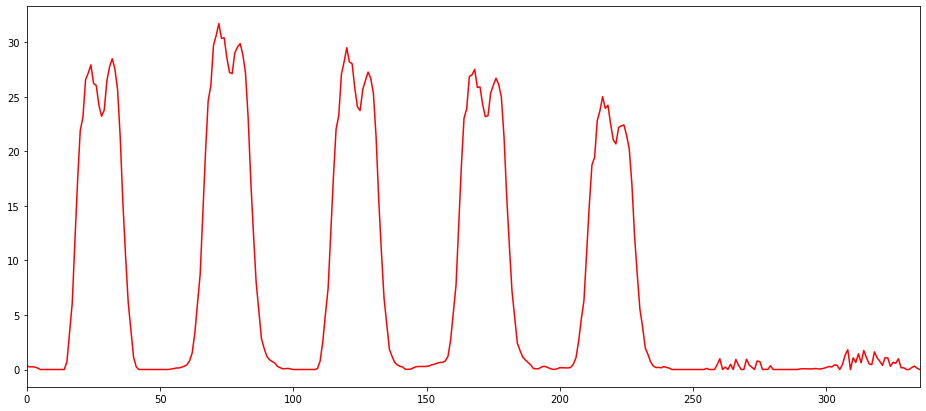

In [259]:
plt.figure(figsize=(16,7))
fin['yhat'].plot(color='red')

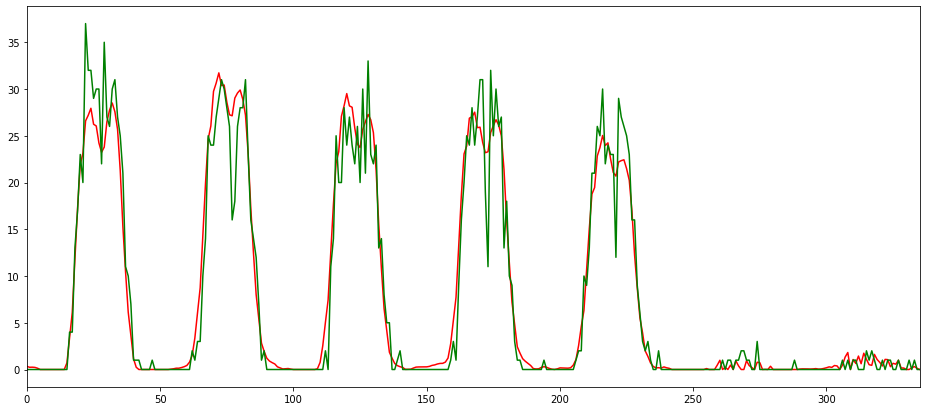

In [260]:
plt.figure(figsize=(16,7))
fin['yhat'].plot(color='red')
fin['traffic_count'].plot(color='green')
plt.show()

In [261]:
fin[['traffic_count','yhat']].sum()

traffic_count    2459.000000
yhat             2507.266433
dtype: float64

In [236]:
fin['area_id'] = 26
fin['client_id'] = 17
fin_ = fin[['client_id','area_id','ds','traffic_count','yhat']]
fin_['res'] = fin_.yhat -  fin_.traffic_count

C:\Users\shree\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [237]:
fin_.describe().T#[(fin_.date == '2020-01-31')]

,count,mean,std,min,25%,50%,75%,max
client_id,336.0,17.000000,0.000000,17.000000,17.000000,17.000000,17.000000,17.000000
area_id,336.0,26.000000,0.000000,26.000000,26.000000,26.000000,26.000000,26.000000
traffic_count,336.0,7.318452,10.904870,0.000000,0.000000,0.000000,14.000000,37.000000
yhat,336.0,7.462102,10.679278,0.000000,0.059154,0.643744,17.030082,31.727949
res,336.0,0.143650,2.513318,-11.211518,-0.385013,0.057145,0.643807,12.289878


In [238]:
fin_ = fin_.rename(columns={'ds':'date_time','yhat':'pred_traffic_bsd_model'})
fin_['date'] = pd.to_datetime(fin_['date_time']).dt.date
dsd = pd.DataFrame(fin_.groupby(['date'])['traffic_count','pred_traffic_bsd_model'].sum())
dsd.reset_index(inplace=True)



In [120]:
fin.traffic_count.std()

10.904870279223017

In [121]:
fin.yhat.std()

10.51227150050354

In [122]:
fin_['pred_traffic_bsd_paper'] = 0
fin_['pred_traffic_bsd_ttp'] = 0
fin_['pred_traffic_bsd_trash'] = 0
fin_['pred_traffic_mean'] = 0

fin_ = fin_[['client_id','area_id','date_time','date','pred_traffic_bsd_paper',
       'pred_traffic_bsd_ttp', 'pred_traffic_bsd_trash', 'pred_traffic_mean','pred_traffic_bsd_model']]

In [123]:
fin_.head()

,client_id,area_id,date_time,date,pred_traffic_bsd_paper,pred_traffic_bsd_ttp,pred_traffic_bsd_trash,pred_traffic_mean,pred_traffic_bsd_model
0,17,26,2020-01-27 00:00:00,2020-01-27,0,0,0,0,0.303889
1,17,26,2020-01-27 00:30:00,2020-01-27,0,0,0,0,0.221826
2,17,26,2020-01-27 01:00:00,2020-01-27,0,0,0,0,0.238350
3,17,26,2020-01-27 01:30:00,2020-01-27,0,0,0,0,0.218821
4,17,26,2020-01-27 02:00:00,2020-01-27,0,0,0,0,0.130919


In [124]:
test_set = fcst[(fcst.ds >= '2020-01-27 00:00:00')]
test_set.reset_index(inplace=True)

In [125]:
act_.head()

,ds,traffic_count
0,2020-01-27 00:00:00,0
1,2020-01-27 00:30:00,0
2,2020-01-27 01:00:00,0
3,2020-01-27 01:30:00,0
4,2020-01-27 02:00:00,0


In [127]:
#fcst[(fcst.ds >= '2020-01-27 00:00:00')]#[['ds', 'trend', 'yhat_lower', 'yhat_upper','yhat']]

In [128]:
new = act_
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(new, test_set)
cmp_df.tail(n=3)

cmp_df.reset_index(inplace=True)
print(cmp_df.shape)

print(cmp_df.isnull().sum())

original = cmp_df.dropna()

original.reset_index(inplace=True)

original=original.drop(['index'],axis=1)

original['ds'] = original['ds'].astype(str)
original.set_index(['ds'],inplace=True)

(368, 5)
ds                0
yhat              0
yhat_lower        0
yhat_upper        0
traffic_count    32
dtype: int64


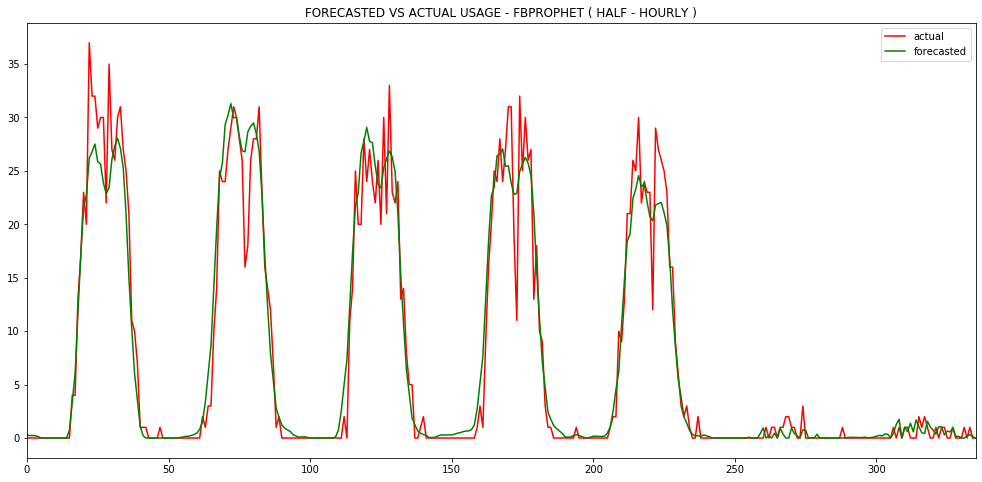

In [183]:
original['yhat'] = np.where(original['yhat'] < 0, 0 ,original['yhat'])
plt.figure(figsize=(17,8))
original['traffic_count'].plot(color='red',label='actual')
original['yhat'].plot(color='green',label='forecasted')
plt.legend(loc='best')
plt.title("FORECASTED VS ACTUAL USAGE - FBPROPHET ( HALF - HOURLY )")
plt.show()

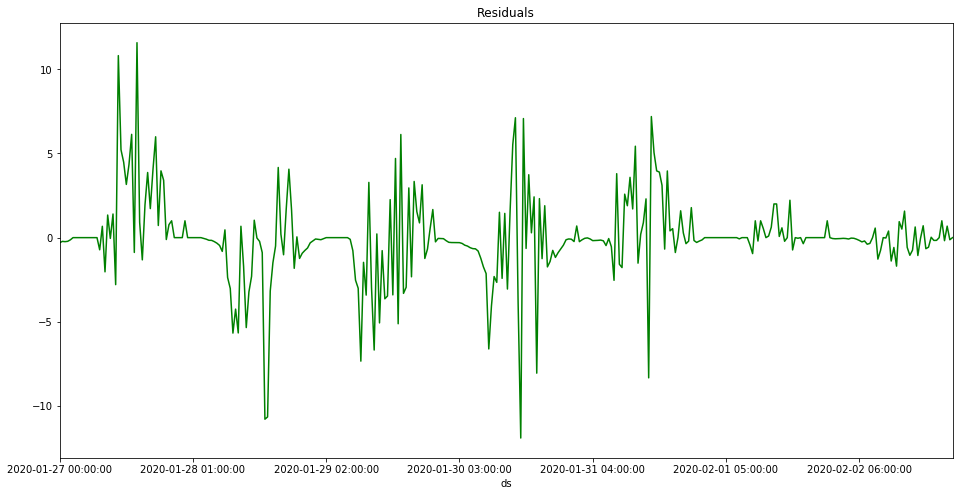

In [132]:
original['residuals'] = original['traffic_count'] - original['yhat']

plt.figure(figsize=(16,8))
original['residuals'].plot(color='green',label='residuals')
plt.title("Residuals")
plt.show()

In [133]:
original.reset_index(inplace=True)

In [134]:
original.describe().T

,count,mean,std,min,25%,50%,75%,max
yhat,336.0,7.352618,10.512272,0.000000,0.063129,0.633535,16.763875,31.296340
yhat_lower,336.0,-502.416993,705.669395,-2088.911700,-1125.826890,-51.835391,-15.233835,-3.351998
yhat_upper,336.0,543.852713,765.156573,3.233725,15.294652,51.799359,1213.836771,2256.257623
traffic_count,336.0,7.318452,10.904870,0.000000,0.000000,0.000000,14.000000,37.000000
residuals,336.0,-0.034166,2.520057,-11.899277,-0.620672,-0.043582,0.472823,11.575939


In [135]:
original['hour'] = pd.to_datetime(original.ds).dt.hour
original['date'] = pd.to_datetime(original.ds).dt.date

In [169]:
converted_hrly = pd.DataFrame(original.groupby(['date','hour'])['yhat'].sum())
converted_hrly.reset_index(inplace=True)
converted_hrly['date_time'] = converted_hrly.date.astype(str) + " " + converted_hrly.hour.astype(str) + ":" +"00" + ":" + "00"
converted_hrly['yhat'] = np.floor(converted_hrly['yhat'])

In [170]:
act_['hour'] = pd.to_datetime(act_.ds).dt.hour

In [171]:
act_converted_hrly = pd.DataFrame(act_.groupby(['date','hour'])['traffic_count'].sum())
act_converted_hrly.reset_index(inplace=True)

In [172]:
act_pred = pd.merge(converted_hrly,act_converted_hrly,on=['date','hour'],how='inner')

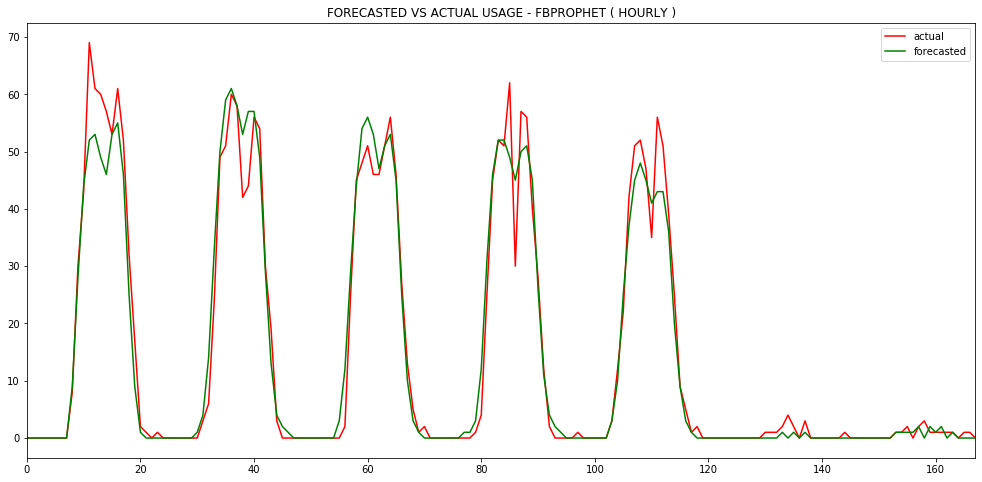

In [173]:
act_pred['yhat'] = np.where(act_pred['yhat'] < 0, 0 ,act_pred['yhat'])
plt.figure(figsize=(17,8))
act_pred['traffic_count'].plot(color='red',label='actual')
act_pred['yhat'].plot(color='green',label='forecasted')
plt.legend(loc='best')
plt.title("FORECASTED VS ACTUAL USAGE - FBPROPHET ( HOURLY )")
plt.show()

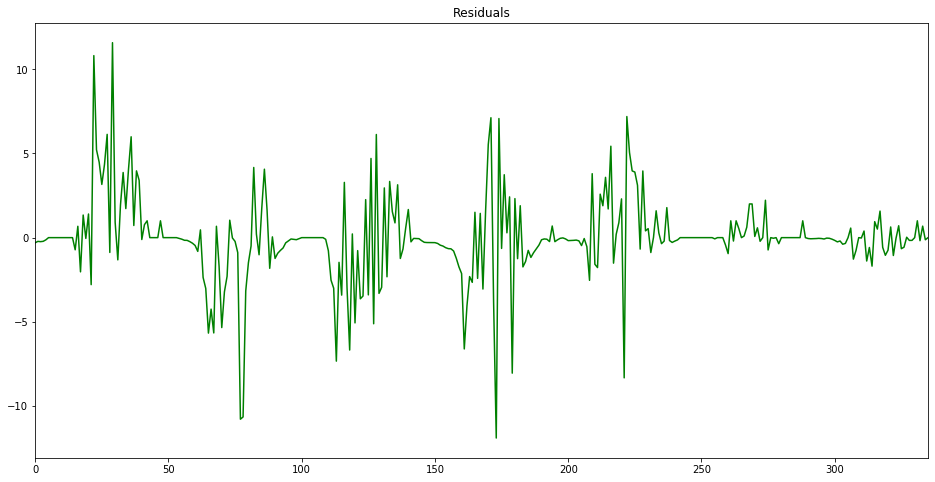

In [174]:
act_pred['residuals'] = act_pred['traffic_count'] - act_pred['yhat']

plt.figure(figsize=(16,8))
original['residuals'].plot(color='green',label='residuals')
plt.title("Residuals")
plt.show()

In [175]:
act_pred.describe().T

,count,mean,std,min,25%,50%,75%,max
hour,168.0,11.500000,6.942881,0.0,5.75,11.5,17.25,23.0
yhat,168.0,14.327381,20.897955,0.0,0.00,1.0,29.50,61.0
traffic_count,168.0,14.636905,21.572445,0.0,0.00,1.0,30.00,69.0
residuals,168.0,0.309524,4.002922,-15.0,0.00,0.0,1.00,17.0


In [176]:
metric_df_converted = act_pred
metric_df_converted.dropna(inplace=True)
metric_df_converted['yhat'] = np.where(metric_df_converted.yhat < 0 , 0 , metric_df_converted.yhat)
metric_df_converted['yhat'] = np.floor(metric_df_converted.yhat)

In [177]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import ml_metrics as metrics

print('r squared : ' , (r2_score(metric_df_converted.traffic_count, metric_df_converted.yhat)* 100))

print('mean squared error : ' , mean_squared_error(metric_df_converted.traffic_count, metric_df_converted.yhat))

print('mean absolute error : ' , mean_absolute_error(metric_df_converted.traffic_count, metric_df_converted.yhat))

print('Root mean sqauared error : ' , metrics.rmse(metric_df_converted.traffic_count, metric_df_converted.yhat))

r squared :  96.5361437593474
mean squared error :  16.023809523809526
mean absolute error :  2.130952380952381
Root mean sqauared error :  4.002975084085526
